# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.emfiles import crop_fourier_images, crop_fourier_volume
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import conjugate_gradient, get_cg_vol_ops
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

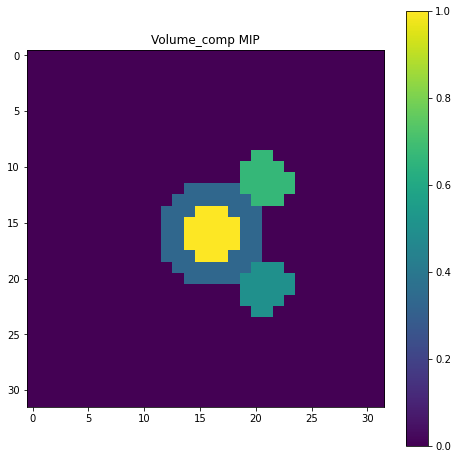

In [3]:
nx = 32
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0], [0,0,3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10,15,20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

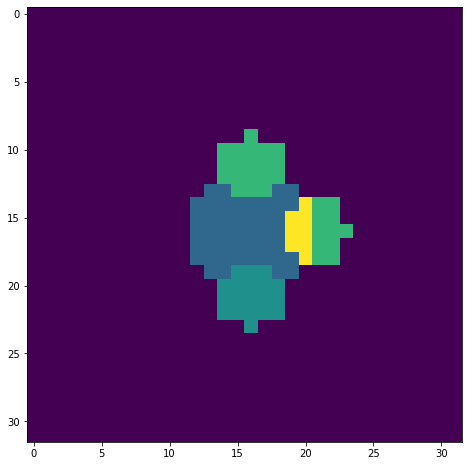

In [4]:
mip_y(vol)

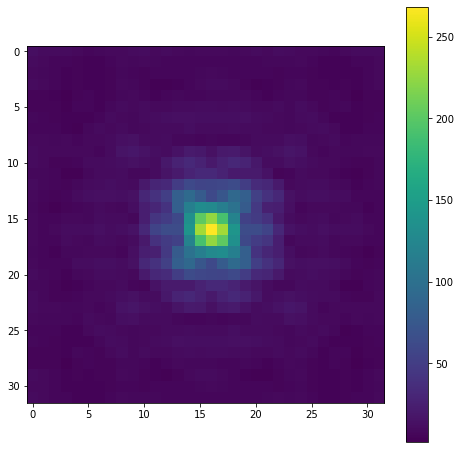

In [5]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [6]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


Generate projections (in Fourier domain)

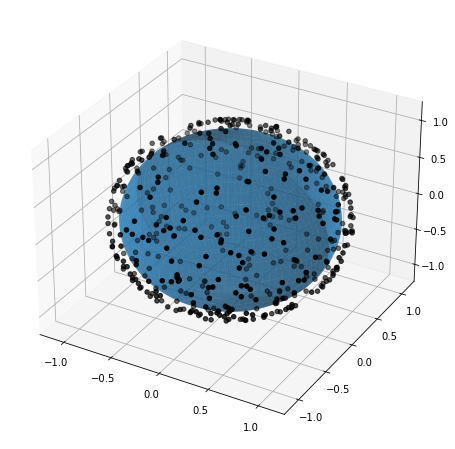

In [7]:
# Orientations
N = 4000

#s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
#jnp.array(np.random.rand(N,3))*jnp.pi*2

#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(2250,3), 
#                             s*np.random.randn(2250,3)+np.pi*2/3, 
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

In [8]:
angles_true.shape

(4000, 3)

3.64247727394104
0.400827308364389


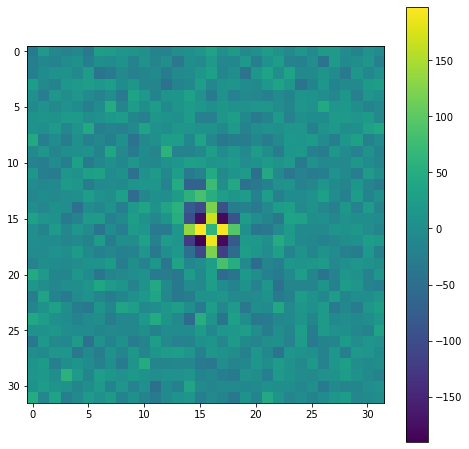

In [9]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

norm0 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

norm1 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

print(time.time()-start)

#SNR
print(norm0/norm1)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [10]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx*nx)
    #imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

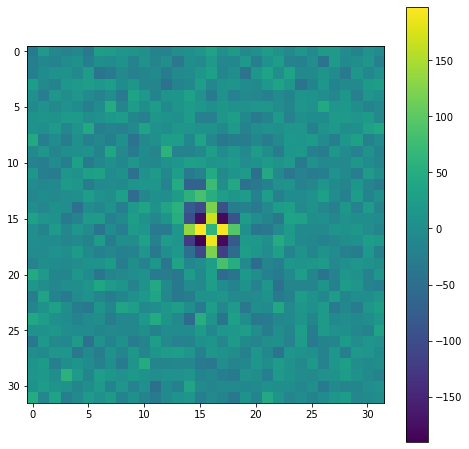

In [11]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

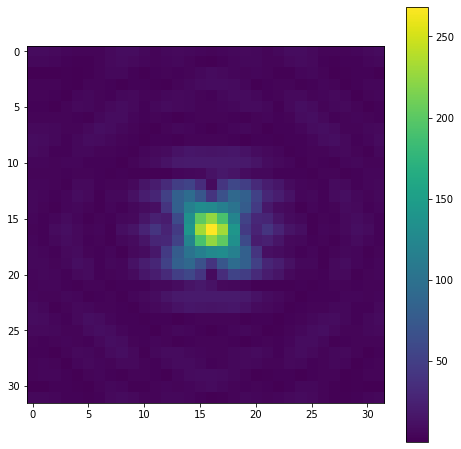

In [12]:
#mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:,:,0])))); plt.colorbar()

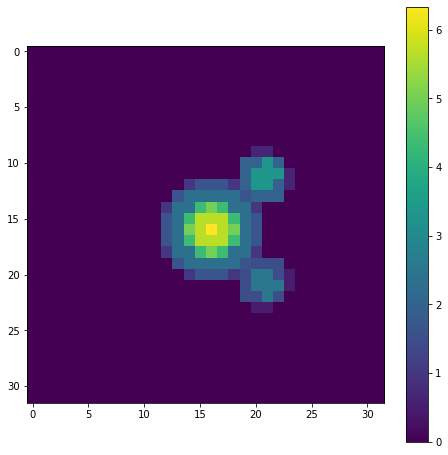

In [13]:
#mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:,:,0])))); plt.colorbar()

### Loss functions for the new dimension

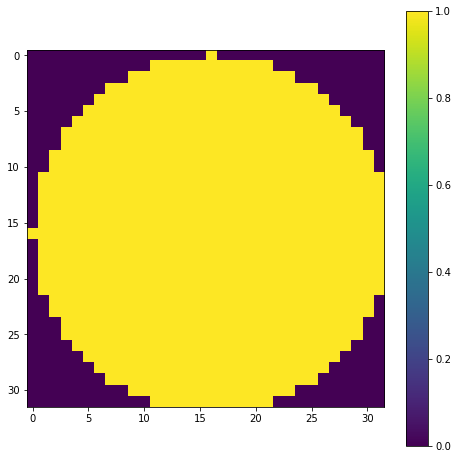

In [14]:
#alpha = 0.01
alpha = 0

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [15]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
#ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

6.306508541107178
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [16]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(ll.shape)

2.555804967880249
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [17]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

3.4108364582061768
(32, 32, 32)


### Orientations

In [18]:
def get_relevant_jax_ops(x_grid, mask):
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    return slice_func_array_angles, grad_loss_volume_sum

In [19]:
# Here, we generate new random orientations for each image, no storing of projections.

loss_func_angles = jax.jit(jax.vmap(loss_func, in_axes = (None, 0, None, None, None)))

def sample_new_angles_one_img(loss_func_angles, vol, shifts_true, ctf_params, img, N_samples):
    ang_samples = generate_uniform_orientations(N_samples)
    loss = loss_func_angles(vol, ang_samples, shifts_true, ctf_params, img)
    li = jnp.argmin(loss)
    return ang_samples[li]

def sample_new_angles(loss_func_angles, vol, shifts_true, ctf_params, imgs, N_samples):
    angles = []
    for ai in range(N):
        ang_samples = generate_uniform_orientations(N_samples)
        loss = loss_func_angles(vol, ang_samples, shifts_true[ai], ctf_params[ai], imgs[ai])
        li = jnp.argmin(loss)
        angles.append(ang_samples[li])
    return jnp.array(angles) 

sample_new_angles_vmap = jax.vmap(sample_new_angles_one_img, in_axes = (None, None, 0, 0, 0, None))

In [20]:
# Alternative approach where we generate the same N_samples orientations, store the projected
# images and compare each data image with the projections. Should be faster.

def loss_func_imgs_batched(img0, imgs):
    """Compute the loss between img0 and each image in the imgs array."""
    return jax.vmap(l2sq, in_axes = (None, 0))(img0, imgs)


def get_min_loss_index(img0, imgs, loss_func_array):
    """Given img0 and the array imgs, return the index in imgs of the image
    with the lowest loss with img0."""
    
    loss = loss_func_array(img0, imgs) 
    return jnp.argmin(loss)

def get_min_loss_indices(imgs1, imgs2, loss_func_array):
    return jax.vmap(get_min_loss_index, in_axes=(0, None, None))(imgs1, imgs2, loss_func_array)

def sample_new_angles_cached(loss_func_imgs_batched, slice_func_array_angles, vol, shifts_true, ctf_params, imgs, N_samples):
    ang_samples = generate_uniform_orientations(N_samples)
    imgs_sampled = slice_func_array_angles(vol, ang_samples, shifts_true, ctf_params)
    indices = get_min_loss_indices(imgs, imgs_sampled, loss_func_imgs_batched) 
        
    return ang_samples[indices]

Iter 0 ||r|| = 0.041300249905638776
Iter 50 ||r|| = 8.574325147902463e-05
Iter 100 ||r|| = 5.111813223083405e-05
Iter 150 ||r|| = 4.1999202692597064e-05
Iter 200 ||r|| = 3.681285228873127e-05
Iter 250 ||r|| = 3.300768058274114e-05


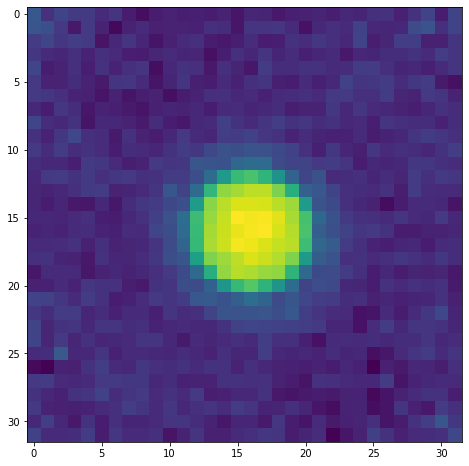

In [21]:
N_samples = 40000
N_iter = 100
N_cg_iter = 300
dr = 0.05
radius = 0.1

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
angles = generate_uniform_orientations(N)

imgs = imgs.reshape([N, nx*nx])
AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles, shifts_true, ctf_params, imgs, v0.shape)
vcg, _ = conjugate_gradient(AA, Ab, v0, N_cg_iter, verbose=True)
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[0,:,:]))))
imgs = imgs.reshape([N, nx,nx])

Iter  0
time angles = 5.170083522796631
Iter 0 ||r|| = 1.9714741155415665
Iter 50 ||r|| = 4.16295114144342e-05
Iter 100 ||r|| = 4.119197754063621e-05
Iter 150 ||r|| = 2.5479330292302475e-05
Iter 200 ||r|| = 2.3885865643668545e-05
Iter 250 ||r|| = 2.18265894759248e-05
time cg = 7.683630704879761


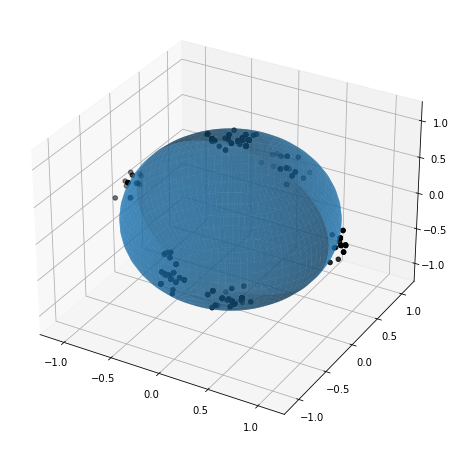

Iter  1
time angles = 3.0616135597229004
Iter 0 ||r|| = 1.0456267307160434
Iter 50 ||r|| = 0.0029951881618415026
Iter 100 ||r|| = 0.0008290112810481302
Iter 150 ||r|| = 0.00028415463386623907
Iter 200 ||r|| = 0.0001581593312978964
Iter 250 ||r|| = 0.00010228962794807522
time cg = 10.764036178588867
Iter  2
time angles = 2.232203483581543
Iter 0 ||r|| = 0.676362636352769
Iter 50 ||r|| = 9.248950016628879e-05
Iter 100 ||r|| = 6.249593180477912e-05
Iter 150 ||r|| = 4.8535332998453677e-05
Iter 200 ||r|| = 3.718701391934988e-05
Iter 250 ||r|| = 3.0049212874385965e-05
time cg = 6.714674949645996
Iter  3
time angles = 2.3072991371154785
Iter 0 ||r|| = 0.6870983921820173
Iter 50 ||r|| = 9.37228381742221e-05
Iter 100 ||r|| = 7.147980500360186e-05
Iter 150 ||r|| = 5.261842849346422e-05
Iter 200 ||r|| = 3.6268803802371674e-05
Iter 250 ||r|| = 3.710744484064513e-05
time cg = 6.711943864822388
Iter  4
time angles = 2.070206880569458
Iter 0 ||r|| = 0.6792878133752853
Iter 50 ||r|| = 0.00010645382895

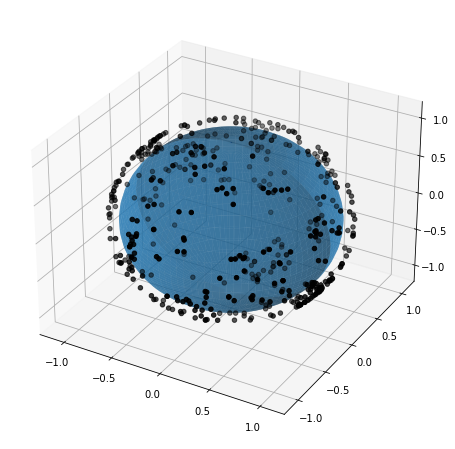

Iter  5
time angles = 3.0186445713043213
Iter 0 ||r|| = 0.5005933813779998
Iter 50 ||r|| = 7.745130454984998e-05
Iter 100 ||r|| = 5.051804526726149e-05
Iter 150 ||r|| = 4.4148981299640495e-05
Iter 200 ||r|| = 2.8934742782165908e-05
Iter 250 ||r|| = 3.2745169661926326e-05
time cg = 11.331700086593628
Iter  6
time angles = 2.138850688934326
Iter 0 ||r|| = 0.5017821533051415
Iter 50 ||r|| = 0.00010341238931621969
Iter 100 ||r|| = 4.9553225063795215e-05
Iter 150 ||r|| = 4.213346084831906e-05
Iter 200 ||r|| = 3.8832782729243966e-05
Iter 250 ||r|| = 2.8766821350765083e-05
time cg = 7.377947568893433
Iter  7
time angles = 2.2487642765045166
Iter 0 ||r|| = 0.5137116805951519
Iter 50 ||r|| = 8.77345594507506e-05
Iter 100 ||r|| = 4.5160181160983345e-05
Iter 150 ||r|| = 3.670357574354344e-05
Iter 200 ||r|| = 3.063933869087065e-05
Iter 250 ||r|| = 2.6348429933358713e-05
time cg = 7.308051347732544
Iter  8
time angles = 2.671494960784912
Iter 0 ||r|| = 0.5224435844170036
Iter 50 ||r|| = 7.056958296

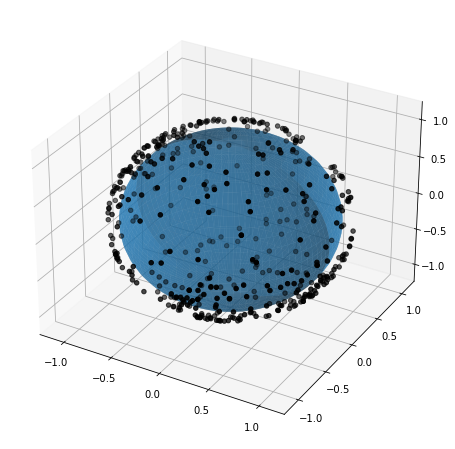

Iter  9
time angles = 2.7411439418792725
Iter 0 ||r|| = 0.3985577028453982
Iter 50 ||r|| = 8.991372156936663e-05
Iter 100 ||r|| = 4.995922935662908e-05
Iter 150 ||r|| = 4.27007763720308e-05
Iter 200 ||r|| = 3.8456036100664524e-05
Iter 250 ||r|| = 3.63333028682552e-05
time cg = 11.58370304107666
Iter  10
time angles = 2.5129611492156982
Iter 0 ||r|| = 0.40546282320642724
Iter 50 ||r|| = 6.843562331253717e-05
Iter 100 ||r|| = 3.947816181271751e-05
Iter 150 ||r|| = 3.615272536152682e-05
Iter 200 ||r|| = 2.892569639939903e-05
Iter 250 ||r|| = 2.876120979187202e-05
time cg = 7.365660905838013
Iter  11
time angles = 2.1257669925689697
Iter 0 ||r|| = 0.4002401090255709
Iter 50 ||r|| = 8.96888020400483e-05
Iter 100 ||r|| = 6.026843914520513e-05
Iter 150 ||r|| = 4.1499715195017314e-05
Iter 200 ||r|| = 3.270765113841229e-05
Iter 250 ||r|| = 3.099785953738415e-05
time cg = 7.851242542266846
Iter  12
time angles = 2.6566619873046875
Iter 0 ||r|| = 0.3999414304434138
Iter 50 ||r|| = 7.8056025164526

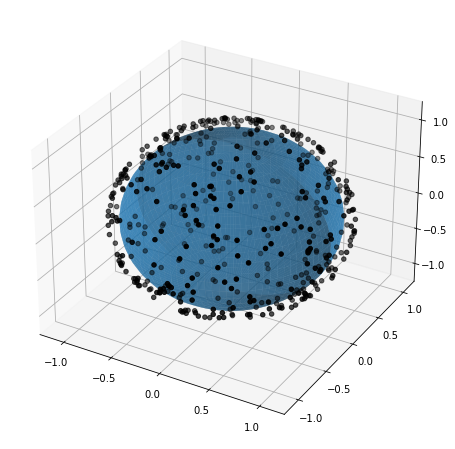

Iter  13
time angles = 2.167738676071167
Iter 0 ||r|| = 0.4132047989855976
Iter 50 ||r|| = 9.995308763935024e-05
Iter 100 ||r|| = 5.635088815304646e-05
Iter 150 ||r|| = 4.155813053668409e-05
Iter 200 ||r|| = 3.8483822606231746e-05
Iter 250 ||r|| = 3.077964355153997e-05
time cg = 7.435961484909058
Iter  14
time angles = 2.124300479888916
Iter 0 ||r|| = 0.4201556110152594
Iter 50 ||r|| = 0.00011991483019825258
Iter 100 ||r|| = 6.596421272759255e-05
Iter 150 ||r|| = 5.150705591026204e-05
Iter 200 ||r|| = 5.273663421619364e-05
Iter 250 ||r|| = 3.728823523671838e-05
time cg = 7.773263216018677
Iter  15
time angles = 2.2584784030914307
Iter 0 ||r|| = 0.4205982845150296
Iter 50 ||r|| = 8.5068575021742e-05
Iter 100 ||r|| = 5.945745516325955e-05
Iter 150 ||r|| = 4.407493010216089e-05
Iter 200 ||r|| = 4.6798915716401396e-05
Iter 250 ||r|| = 3.282234176262519e-05
time cg = 7.558884143829346
Iter  16
time angles = 2.363956928253174
Iter 0 ||r|| = 0.42072375311719534
Iter 50 ||r|| = 8.6102053544719

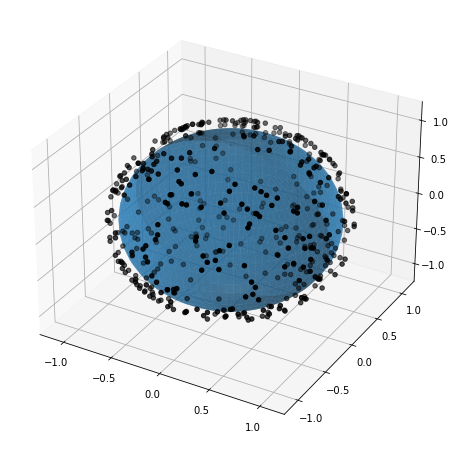

Iter  17
time angles = 3.1935014724731445
Iter 0 ||r|| = 0.31441259613863404
Iter 50 ||r|| = 0.00011817742843365538
Iter 100 ||r|| = 4.9005599027861666e-05
Iter 150 ||r|| = 5.0187275999965306e-05
Iter 200 ||r|| = 3.633611914523412e-05
Iter 250 ||r|| = 3.598940221064557e-05
time cg = 13.675330877304077
Iter  18
time angles = 2.5025017261505127
Iter 0 ||r|| = 0.3178825501490614
Iter 50 ||r|| = 0.00010069831254278318
Iter 100 ||r|| = 6.026053369534417e-05
Iter 150 ||r|| = 4.0146749316611145e-05
Iter 200 ||r|| = 3.890128946168364e-05
Iter 250 ||r|| = 2.9958196742792942e-05
time cg = 8.87686276435852
Iter  19
time angles = 2.3096423149108887
Iter 0 ||r|| = 0.3181063453724624
Iter 50 ||r|| = 8.424376292790436e-05
Iter 100 ||r|| = 5.700950364695035e-05
Iter 150 ||r|| = 3.824498447175685e-05
Iter 200 ||r|| = 3.896884525403519e-05
Iter 250 ||r|| = 2.7553106236677572e-05
time cg = 8.989486455917358
Iter  20
time angles = 2.4305708408355713
Iter 0 ||r|| = 0.318152312731105
Iter 50 ||r|| = 0.00010

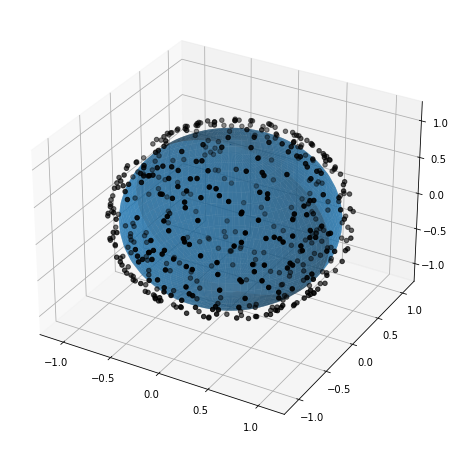

Iter  21
time angles = 3.170924663543701
Iter 0 ||r|| = 0.24568781760171743
Iter 50 ||r|| = 9.948066723350279e-05
Iter 100 ||r|| = 4.948078940594062e-05
Iter 150 ||r|| = 4.6825596920937965e-05
Iter 200 ||r|| = 4.597883185328636e-05
Iter 250 ||r|| = 3.174991493639807e-05
time cg = 12.322838306427002
Iter  22
time angles = 2.198479175567627
Iter 0 ||r|| = 0.24560655136673631
Iter 50 ||r|| = 8.414125772581551e-05
Iter 100 ||r|| = 4.760959260968093e-05
Iter 150 ||r|| = 3.3755725506760054e-05
Iter 200 ||r|| = 3.411955928940714e-05
Iter 250 ||r|| = 2.8468428031768926e-05
time cg = 9.088119506835938
Iter  23
time angles = 2.1652779579162598
Iter 0 ||r|| = 0.24602461426396197
Iter 50 ||r|| = 0.00010253675377437206
Iter 100 ||r|| = 8.320931967480001e-05
Iter 150 ||r|| = 4.4373398377275324e-05
Iter 200 ||r|| = 3.732399176757344e-05
Iter 250 ||r|| = 3.733803147128858e-05
time cg = 9.202280282974243
Iter  24
time angles = 2.2643580436706543
Iter 0 ||r|| = 0.24627099316823164
Iter 50 ||r|| = 0.0001

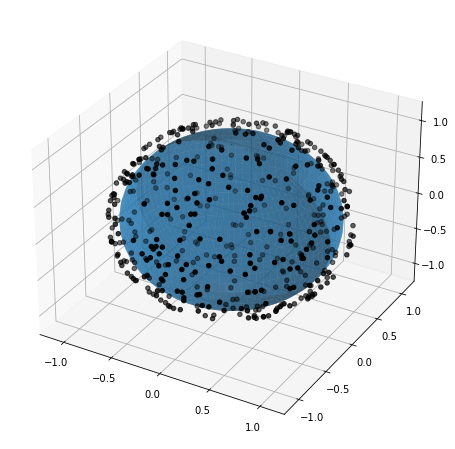

Iter  25
time angles = 3.5001060962677
Iter 0 ||r|| = 0.19476060281798754
Iter 50 ||r|| = 8.144801704590806e-05
Iter 100 ||r|| = 5.188027761210835e-05
Iter 150 ||r|| = 3.9717771334707524e-05
Iter 200 ||r|| = 3.9158770652258195e-05
Iter 250 ||r|| = 3.2526225375699176e-05
time cg = 16.33158540725708
Iter  26
time angles = 2.256073236465454
Iter 0 ||r|| = 0.1945639621954775
Iter 50 ||r|| = 0.00010807908058395983
Iter 100 ||r|| = 7.006764037617611e-05
Iter 150 ||r|| = 4.492158365564123e-05
Iter 200 ||r|| = 3.940683668833536e-05
Iter 250 ||r|| = 3.397464996773477e-05
time cg = 11.724623441696167
Iter  27
time angles = 2.2787792682647705
Iter 0 ||r|| = 0.19498987138648785
Iter 50 ||r|| = 0.00010889530582297531
Iter 100 ||r|| = 7.735745121446583e-05
Iter 150 ||r|| = 3.9962959185737904e-05
Iter 200 ||r|| = 4.5726987226949294e-05
Iter 250 ||r|| = 3.7572519473151885e-05
time cg = 12.144423723220825
Iter  28
time angles = 2.215939998626709
Iter 0 ||r|| = 0.19485725028155823
Iter 50 ||r|| = 9.7270

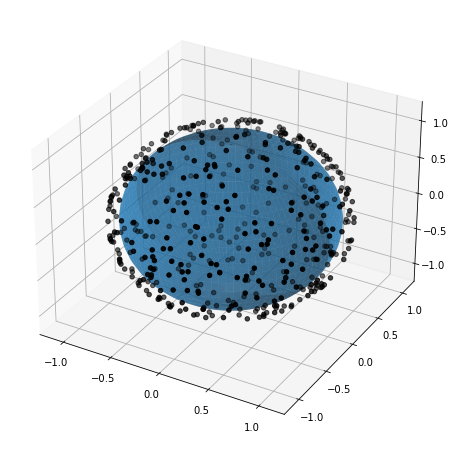

Iter  29
time angles = 2.9981532096862793
Iter 0 ||r|| = 0.15802342810067763
Iter 50 ||r|| = 8.525570413581858e-05
Iter 100 ||r|| = 4.9898842632240346e-05
Iter 150 ||r|| = 4.61438850153441e-05
Iter 200 ||r|| = 3.7475387284783564e-05
Iter 250 ||r|| = 3.07303991958353e-05
time cg = 17.814003705978394
Iter  30
time angles = 2.300779104232788
Iter 0 ||r|| = 0.1577393670717027
Iter 50 ||r|| = 0.0001240271175289482
Iter 100 ||r|| = 6.686395907553286e-05
Iter 150 ||r|| = 4.394701922873935e-05
Iter 200 ||r|| = 3.543788585166606e-05
Iter 250 ||r|| = 3.635574495188532e-05
time cg = 13.92974305152893
Iter  31
time angles = 2.35357403755188
Iter 0 ||r|| = 0.15775946377860053
Iter 50 ||r|| = 8.891439240642353e-05
Iter 100 ||r|| = 4.895402480597761e-05
Iter 150 ||r|| = 4.5958883063846536e-05
Iter 200 ||r|| = 3.86542187243147e-05
Iter 250 ||r|| = 3.714272521191896e-05
time cg = 13.599810361862183
Iter  32
time angles = 2.2220330238342285
Iter 0 ||r|| = 0.15767695741093687
Iter 50 ||r|| = 0.0001080812

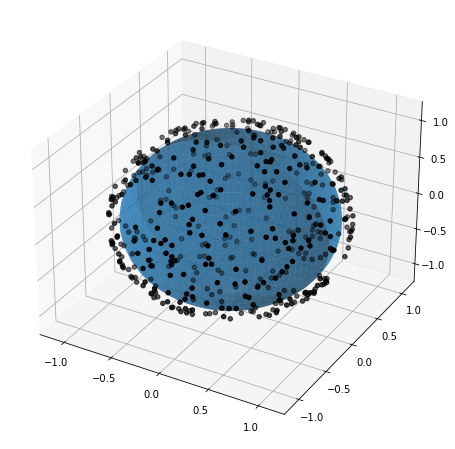

Iter  33
time angles = 3.3508002758026123
Iter 0 ||r|| = 0.13076529161510658
Iter 50 ||r|| = 9.97473115113831e-05
Iter 100 ||r|| = 7.51889551664214e-05
Iter 150 ||r|| = 4.690644734049678e-05
Iter 200 ||r|| = 3.4824303448752275e-05
Iter 250 ||r|| = 3.9374442870173984e-05
time cg = 21.385444402694702
Iter  34
time angles = 2.3981456756591797
Iter 0 ||r|| = 0.1310181440887725
Iter 50 ||r|| = 0.00010290547967532884
Iter 100 ||r|| = 6.90141663613931e-05
Iter 150 ||r|| = 4.29824434891198e-05
Iter 200 ||r|| = 3.920892093623343e-05
Iter 250 ||r|| = 3.445203579662414e-05
time cg = 16.12033200263977
Iter  35
time angles = 2.3442881107330322
Iter 0 ||r|| = 0.13094227509687464
Iter 50 ||r|| = 9.289286517594365e-05
Iter 100 ||r|| = 7.27007577397023e-05
Iter 150 ||r|| = 4.8617278024186964e-05
Iter 200 ||r|| = 4.673052578018068e-05
Iter 250 ||r|| = 4.072241586526155e-05
time cg = 16.68475604057312
Iter  36
time angles = 2.3658199310302734
Iter 0 ||r|| = 0.13073486870444112
Iter 50 ||r|| = 0.000100676

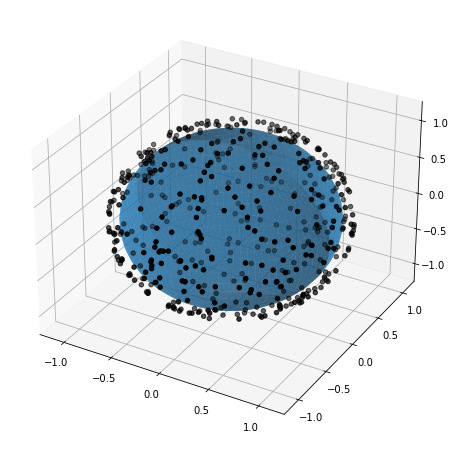

Iter  37
time angles = 3.3213050365448
Iter 0 ||r|| = 0.11013528697801196
Iter 50 ||r|| = 0.00011514452158431451
Iter 100 ||r|| = 5.509131824936315e-05
Iter 150 ||r|| = 4.1651015773321056e-05
Iter 200 ||r|| = 4.0221778953263484e-05
Iter 250 ||r|| = 3.080303341776271e-05
time cg = 22.08724617958069
Iter  38
time angles = 2.3001720905303955
Iter 0 ||r|| = 0.11017566253025525
Iter 50 ||r|| = 0.00011047134070761786
Iter 100 ||r|| = 5.749511358804619e-05
Iter 150 ||r|| = 5.03575092901585e-05
Iter 200 ||r|| = 4.504156776606937e-05
Iter 250 ||r|| = 3.721088730522996e-05
time cg = 17.600186347961426
Iter  39
time angles = 2.2823963165283203
Iter 0 ||r|| = 0.11006948023772224
Iter 50 ||r|| = 0.00012542379092642152
Iter 100 ||r|| = 6.209965380847457e-05
Iter 150 ||r|| = 4.0247971854474e-05
Iter 200 ||r|| = 3.5772111905060714e-05
Iter 250 ||r|| = 2.63438813395935e-05
time cg = 18.606906175613403
Iter  40
time angles = 2.317925214767456
Iter 0 ||r|| = 0.11000529303960023
Iter 50 ||r|| = 0.00011490

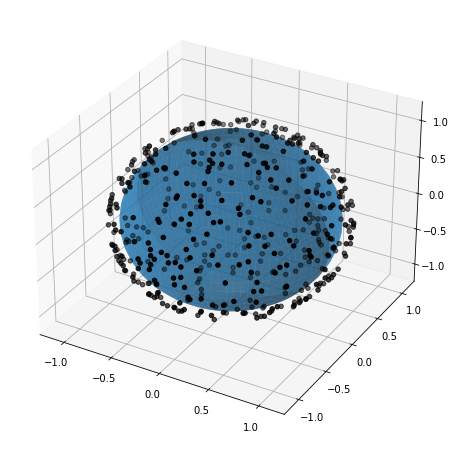

Iter  41
time angles = 3.5852243900299072
Iter 0 ||r|| = 0.08099458009155878
Iter 50 ||r|| = 9.396125585146595e-05
Iter 100 ||r|| = 5.255574235042867e-05
Iter 150 ||r|| = 4.079733632230221e-05
Iter 200 ||r|| = 4.2122014272114375e-05
Iter 250 ||r|| = 3.420816085305865e-05
time cg = 28.54507803916931
Iter  42
time angles = 2.428518056869507
Iter 0 ||r|| = 0.08105738407582268
Iter 50 ||r|| = 9.38181511926563e-05
Iter 100 ||r|| = 6.185638183838273e-05
Iter 150 ||r|| = 4.681808731412123e-05
Iter 200 ||r|| = 4.959196204778035e-05
Iter 250 ||r|| = 3.7717161586030395e-05
time cg = 23.858216524124146
Iter  43
time angles = 3.031080722808838
Iter 0 ||r|| = 0.08121117797270733
Iter 50 ||r|| = 0.00010427359177195432
Iter 100 ||r|| = 5.062774080284581e-05
Iter 150 ||r|| = 5.301570941052505e-05
Iter 200 ||r|| = 3.817787982143822e-05
Iter 250 ||r|| = 3.2212961347005835e-05
time cg = 24.046408653259277
Iter  44
time angles = 2.268812894821167
Iter 0 ||r|| = 0.08110920678371861
Iter 50 ||r|| = 9.037793

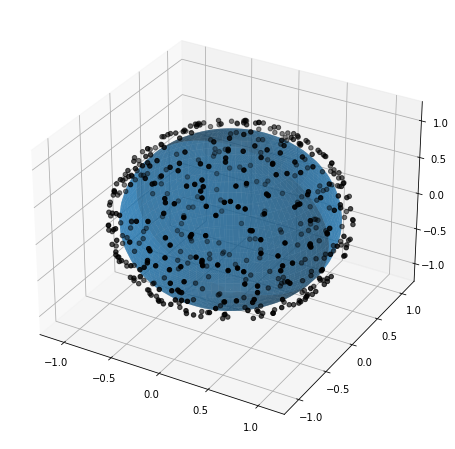

Iter  45
time angles = 3.686976432800293
Iter 0 ||r|| = 0.07067465613135591
Iter 50 ||r|| = 0.00019766395037294033
Iter 100 ||r|| = 5.981913839325527e-05
Iter 150 ||r|| = 5.1839773672243474e-05
Iter 200 ||r|| = 3.9884267225217946e-05
Iter 250 ||r|| = 4.2148799831551505e-05
time cg = 31.970945119857788
Iter  46
time angles = 2.421570062637329
Iter 0 ||r|| = 0.07093094680874264
Iter 50 ||r|| = 0.00011621022112619334
Iter 100 ||r|| = 7.754734398161647e-05
Iter 150 ||r|| = 4.9552749982372066e-05
Iter 200 ||r|| = 3.323495445682097e-05
Iter 250 ||r|| = 3.4668734623680085e-05
time cg = 27.738428831100464
Iter  47
time angles = 2.350301504135132
Iter 0 ||r|| = 0.07075851476151775
Iter 50 ||r|| = 0.00010981606736978203
Iter 100 ||r|| = 6.26411975359359e-05
Iter 150 ||r|| = 6.081475349026283e-05
Iter 200 ||r|| = 4.848567404969953e-05
Iter 250 ||r|| = 3.8418143145410114e-05
time cg = 27.553147554397583
Iter  48
time angles = 2.46706485748291
Iter 0 ||r|| = 0.07033324912087645
Iter 50 ||r|| = 9.52

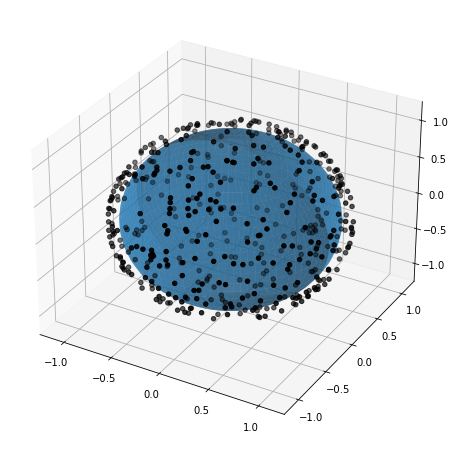

Iter  49
time angles = 3.099843978881836
Iter 0 ||r|| = 0.06202289882870516
Iter 50 ||r|| = 9.928099684044078e-05
Iter 100 ||r|| = 6.555267182879389e-05
Iter 150 ||r|| = 4.625128478088776e-05
Iter 200 ||r|| = 4.555115746402083e-05
Iter 250 ||r|| = 3.4333857405353576e-05
time cg = 27.961958408355713


In [22]:
x_grid_iter = x_grid
vcg_old = v0
for idx in range(N_iter):
    print("Iter ", idx)
    
    mask3d = create_3d_mask(x_grid, (0,0,0),radius)
    
    nx_iter = jnp.sum(mask3d[0,0,:]).astype(jnp.int64)
    
    # Ensure that we work with even images so that all the masking stuff works
    if jnp.mod(nx_iter,2) == 1:
        nx_iter +=1
    
    if idx == 0:
        vcg, _ = crop_fourier_volume(vcg, x_grid, nx_iter)
    else:
        vcg, _, _, _ = rescale_larger_grid(vcg, x_grid_iter, x_grid_iter, x_grid_iter, [nx_iter, nx_iter, nx_iter]) 
        
    imgs_iter, x_grid_iter = crop_fourier_images(imgs, x_grid, nx_iter)
    imgs_iter = imgs_iter.reshape([N,nx_iter*nx_iter])
    mask3d = create_3d_mask(x_grid_iter, (0,0,0),  radius)
    mask2d = mask3d[0].reshape(1,-1)

    slice_func_array_angles_iter, grad_loss_volume_sum_iter  = get_relevant_jax_ops(x_grid_iter, mask3d)

        
    #TODO: make this function return the loss numbers as well so they don't have to be recomputed below
    t0 = time.time()    
    #angles = sample_new_angles_vmap(loss_func_angles, vcg*mask3d, shifts_true, ctf_params, imgs*mask2d, N_samples)    
    angles = sample_new_angles_cached(loss_func_imgs_batched, slice_func_array_angles_iter, vcg*mask3d, shifts_true[0], ctf_params[0], imgs_iter*mask2d, N_samples)    
    print("time angles =", time.time()-t0)
    
    #loss_min = loss_func_sum(vcg*mask3d, angles, shifts_true, ctf_params, imgs)/jnp.sum(mask2d)
    #print("angles loss", loss_min)
    
    t0 = time.time()
    v0 = jnp.array(np.random.randn(nx_iter,nx_iter,nx_iter) + 1j * np.random.randn(nx_iter,nx_iter,nx_iter))
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum_iter, angles, shifts_true, ctf_params, imgs_iter*mask2d, v0.shape)
    old_vcg = vcg
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_cg_iter, verbose=True)
    print("time cg =", time.time()-t0)
    
    #print(old_vcg.shape)
    #print(vcg.shape)
    #vcg = old_vcg*0.95 + vcg*0.05



    if jnp.mod(idx, 4)==0:
        plot_angles(angles[:500])
        plt.show()
        radius += dr

    
    with mrcfile.new('../data/simulated_rec_iter.mrc', overwrite=True) as mrc:
        vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg)))
        mrc.set_data(vr.astype(np.float32))
    
    #plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[:,:,0])*mask2d.reshape(32,32))))
    #plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[:,:,0])))); plt.colorbar()
    #plt.imshow(jnp.abs(jnp.fft.fftshift(vcg[:,:,0] * mask2d.reshape(nx_iter, nx_iter))))
    #plt.show()
    
    if vcg.shape[0] == nx:
        break

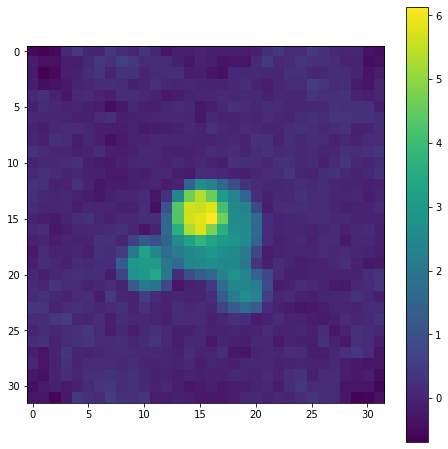

In [23]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[0,:,:])))); plt.colorbar()

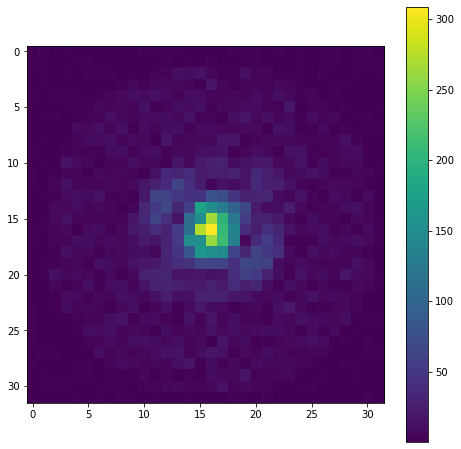

In [24]:
plt.imshow(jnp.abs(jnp.fft.fftshift(vcg[:,:,0]))); plt.colorbar()

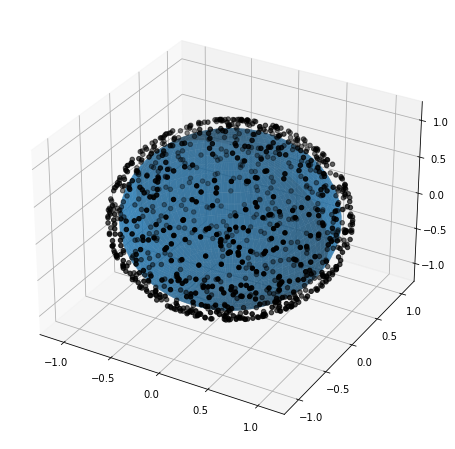

In [25]:
#angles_r = generate_uniform_orientations(400)
plot_angles(angles_true[:1000])

In [26]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg)))
#v0 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier)))

In [27]:
with mrcfile.new('../data/simulated_rec3.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

## Optimization with respect to volume

### CG - applied to two halves of the data

In [28]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 500

N2 = jnp.floor(N/2).astype(jnp.int64)
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

ValueError: Incompatible shapes for broadcasting: ((1, 1024), (32, 32))

In [ ]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

In [ ]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

In [ ]:
#mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; 
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0,:,:])))) ; 
plt.colorbar()

In [ ]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

In [ ]:
#mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:,:,0]))))
plt.colorbar()
#plt.title('Reconstruction slice')

In [ ]:
#mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2[0,:,:]))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### FSC

In [ ]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

In [ ]:
points_v_tri = points_orientations_tri(angles_true[:int(N/2)], x_grid[1])
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0,:,:]*mask[0,:,:]))); plt.colorbar()

In [ ]:
#res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
#plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:,:,0])))); plt.colorbar()

#### Train/test stuff - something's wrong here

In [ ]:
res

In [ ]:
loss = []
for radius in res[1:]:
    mask = create_3d_mask(x_grid, (0,0,0),radius)
    mask_imgs = mask[0,:,:].reshape(1,-1)
    ll = loss_func_sum(vcg1 * mask, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:]*mask_imgs)   
    loss.append(ll)
    
loss = jnp.array(loss)

#plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

In [ ]:
plt.plot(res[1:], loss)

### SGD

In [ ]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
alpha = 10 # this alpha works well for full 128 x 128 x 128 volume with mask
batch_size = 2
N_iter = 1000  
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

In [ ]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

In [ ]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')